In [16]:
# @title Baixando bilbliotecas necessárias
import os;
import matplotlib.pyplot as plt;
import seaborn as sns;
import random;
from PIL import Image;
from torchvision import transforms;
import kagglehub;
import shutil;
import os;
import pandas as pd;

/home/giovani/ProjetoNimbus/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# EDA - Analise Exploratória dos Dados

In [42]:
# @title Baixar e mover o dataset Howard-CloudX
print("Baixando (ou localizando) o dataset no cache...")
path_cache = kagglehub.dataset_download("imbikramsaha/howard-cloudx")
print(f"Origem (Cache): {path_cache}")


destination_path = "./Howard-CloudX-Dataset"


if os.path.exists(destination_path):
    print(f"A pasta '{destination_path}' já existe. Removendo para substituir...")
    shutil.rmtree(destination_path)


print(f"Movendo arquivos para: {os.path.abspath(destination_path)}...")
shutil.move(path_cache, destination_path)

print("\nSucesso! O dataset foi movido e o espaço no cache foi liberado.")
train_dir = destination_path + '/Howard-Cloud-X/train'

class_counts = {}
class_folders = os.listdir(train_dir)

Baixando (ou localizando) o dataset no cache...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275M/275M [00:09<00:00, 29.0MB/s]

Extracting files...


Origem (Cache): /home/giovani/.cache/kagglehub/datasets/imbikramsaha/howard-cloudx/versions/2
A pasta './Howard-CloudX-Dataset' já existe. Removendo para substituir...
Movendo arquivos para: /home/giovani/ProjetoNimbus/Howard-CloudX-Dataset...

Sucesso! O dataset foi movido e o espaço no cache foi liberado.


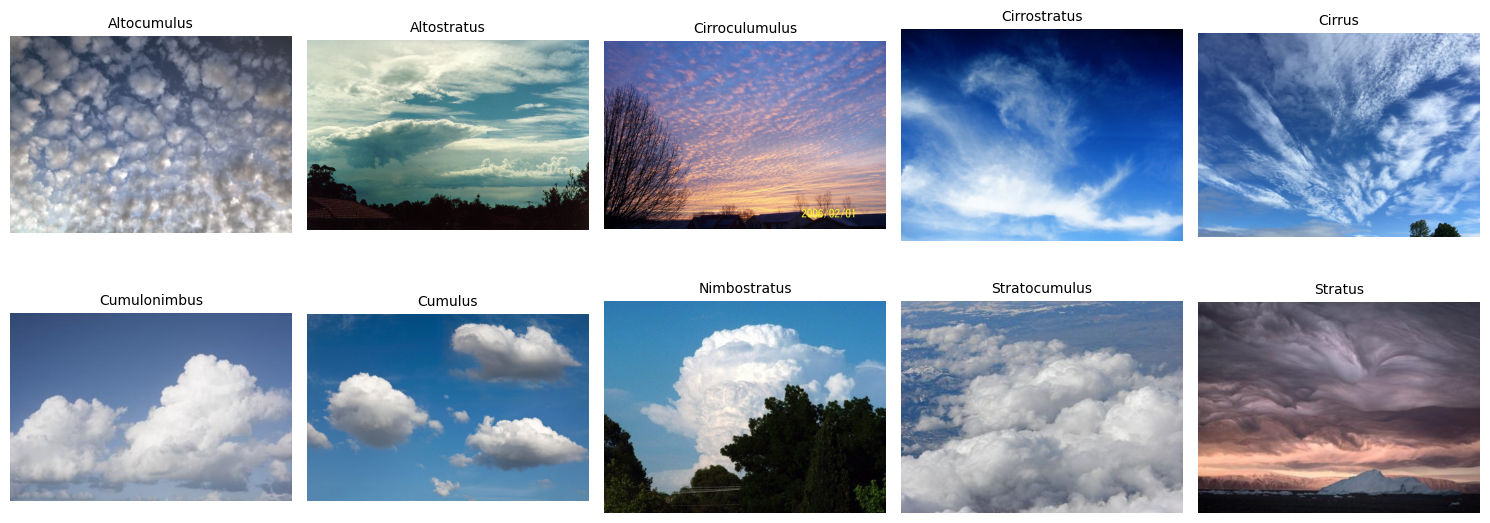

Total de classes exibidas: 10


In [18]:
# @title Exibir amostras de imagens do conjunto de treino

# Determina diretório base de treino
base_dir = train_dir if 'train_dir' in globals() else os.path.join(destination_path, 'Howard-Cloud-X', 'train')

# Obtém lista de classes
classes = class_folders if 'class_folders' in globals() else sorted([
    d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))
])

samples = {}
for cls in classes:
    cls_path = os.path.join(base_dir, cls)
    # Filtra apenas arquivos de imagem comuns
    imgs = [f for f in os.listdir(cls_path) if f.lower().endswith((
        '.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff'
    ))]
    if not imgs:
        continue
    samples[cls] = os.path.join(cls_path, random.choice(imgs))

if not samples:
    print('Nenhuma imagem encontrada para exibição.')
else:
    n = len(samples)
    cols = min(5, n)
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(3 * cols, 3 * rows))

    for i, (cls, path) in enumerate(sorted(samples.items())):
        try:
            img = Image.open(path)
            plt.subplot(rows, cols, i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(cls, fontsize=10)
        except Exception as e:
            print(f'Erro abrindo {path}: {e}')

    plt.tight_layout()
    plt.show()

print('Total de classes exibidas:', len(samples))


Número de tamanhos de imagens diferentes: 501
Menor tamanho de imagem (largura, altura): (214, 136)
Maior tamanho de imagem (largura, altura): (6000, 4000)

Imagens Duplicadas
Sem duplicadas


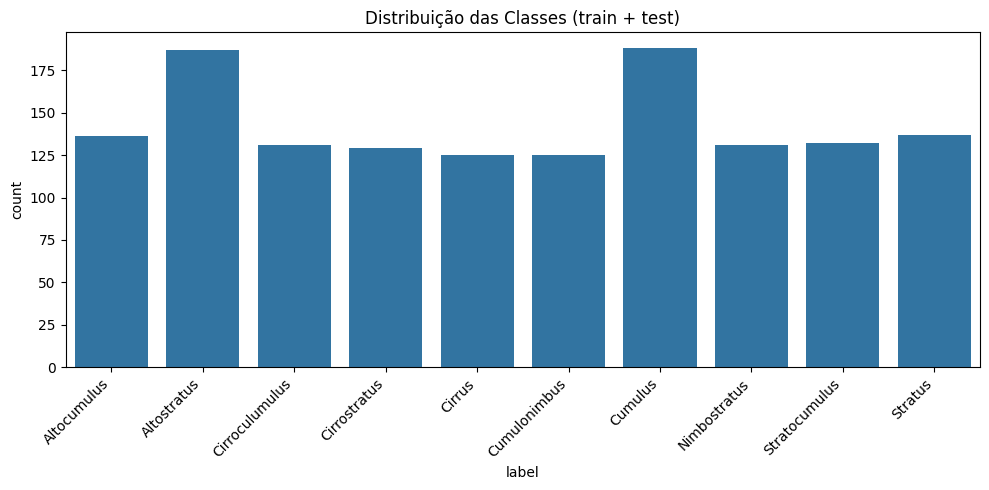

In [19]:
# @title Estatísticas do Dataset

# Define diretório base do dataset de forma robusta
base_dir = os.path.join(destination_path, 'Howard-Cloud-X') if 'destination_path' in globals() else './Howard-CloudX-Dataset/Howard-Cloud-X'

if not os.path.isdir(base_dir):
    raise FileNotFoundError(f"Diretório base não encontrado: {base_dir}")

data_dir = base_dir

# Coleta tamanhos de imagens
image_sizes = set()
for data_type in ['train', 'test']:
    data_type_dir = os.path.join(data_dir, data_type)
    if not os.path.isdir(data_type_dir):
        print(f"Aviso: diretório {data_type_dir} não encontrado.")
        continue
    for class_name in os.listdir(data_type_dir):
        class_dir = os.path.join(data_type_dir, class_name)
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                file_path = os.path.join(class_dir, filename)
                try:
                    with Image.open(file_path) as img:
                        image_sizes.add(img.size)
                except Exception:
                    pass

num_unique_sizes = len(image_sizes)
if image_sizes:
    smallest_size = min(image_sizes, key=lambda x: x[0] * x[1])
    largest_size = max(image_sizes, key=lambda x: x[0] * x[1])
    print(f"\nNúmero de tamanhos de imagens diferentes: {num_unique_sizes}")
    print(f"Menor tamanho de imagem (largura, altura): {smallest_size}")
    print(f"Maior tamanho de imagem (largura, altura): {largest_size}")
else:
    print("Nenhuma imagem encontrada para determinar os tamanhos.")

# Construir DataFrame de caminhos e labels
file_paths = []
labels = []
for data_type in ['train', 'test']:
    data_type_dir = os.path.join(data_dir, data_type)
    if not os.path.isdir(data_type_dir):
        continue
    for class_name in os.listdir(data_type_dir):
        class_dir = os.path.join(data_type_dir, class_name)
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                file_path = os.path.join(class_dir, filename)
                file_paths.append(file_path)
                labels.append(class_name)

if not file_paths:
    print("Nenhum arquivo coletado para análise.")
else:
    df = pd.DataFrame({'file_path': file_paths, 'label': labels})
    duplicates = df[df.duplicated(subset=['file_path'], keep=False)]
    print("\nImagens Duplicadas")
    if not duplicates.empty:
        display(duplicates.sort_values(by='file_path'))
    else:
        print("Sem duplicadas")

    plt.figure(figsize=(10, 5))
    sns.countplot(x='label', data=df, order=sorted(df['label'].unique()))
    plt.xticks(rotation=45, ha='right')
    plt.title('Distribuição das Classes (train + test)')
    plt.tight_layout()
    plt.show()